# Part 0: Set up
Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import datetime
from scipy import stats

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

---
# Part 1: Get (continuous) data

- Continuous data
- Normal distributed

## Generate simulated data (Normal distribution)

In [ ]:
np.random.seed(5)
true_mean_C, true_sigma_C = 20, 3 # Parameters for Group C (Control)
true_mean_T, true_sigma_T = 19, 3 # Parameters for Group T (Treatment)
N = 100_000

data_C = np.random.normal(true_mean_C, true_sigma_C, N)
data_T = np.random.normal(true_mean_T, true_sigma_T, N)

## Sample real data (Google BigQuery)
- 1 day of data

In [ ]:
# User authentication
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Write query
from google.cloud import bigquery
client = bigquery.Client(project='just-data-bq-users')
QUERY = """
  SELECT restaurant_city, order_food_total, order_datetime_local
  FROM `just-data-warehouse.datamart_customer_services.all_order_cs`
  WHERE country = "UK" and order_date_calendar_key = "2023-10-21"
"""

In [ ]:
# Toggle true if running the query is desired (included for "run all" pipeline convenience)
run_query = False

# Execute query and move to DataFrame
if run_query == True:
    # Track total runtime of query
    from datetime import datetime
    _start_time = datetime.now()

    query_job = client.query(QUERY)  # API request
    df_raw = query_job.to_dataframe()

    # Print execution time
    print(f"\n\n\n===============================\nTotal runtime:  {datetime.now() - _start_time}")




Total runtime:  0:00:10.010000


In [ ]:
# Copy such that original df is preserved (preventing need to rerun queries)
df = df_raw.copy()
df.head(5)

,restaurant_city,order_food_total,order_datetime_local
0,Ruislip,38.870351897,2023-10-21 17:55:39.853
1,Ilford,13.071445771,2023-10-21 21:55:14.731
2,Purley,35.510761010,2023-10-21 11:11:03.571
3,Ilford,27.404171396,2023-10-21 16:31:16.177
4,Dartford,45.681263114,2023-10-21 12:52:16.733


In [ ]:
len(df)

864529

**Specify treatment effect:**

In [ ]:
# Treatment effect (in euros)
order_increase_amount = -0.5

Optional: specify start-time for experiment (by default 00:00 am)
- Note: will affect sample size:

In [ ]:
from datetime import time

def start_time_experiment(df, hour, minute):
    # Create a time object for the specified hour and minute
    specified_time = time(hour, minute)

    # Filter the DataFrame
    filtered_df = df[df['order_datetime_local'].dt.time > specified_time]

    # Print new start-time and number of samples that are sliced away
    print(f"start time: {hour}:{minute}, samples lost: {len(df) - len(filtered_df)}")

    return filtered_df

df = start_time_experiment(df, hour = 12, minute = 0)

start time: 12:0, samples lost: 109699


In [ ]:
# Define the proportion of users in the treatment group
treatment_proportion = 0.5

# Round to 2 decimals
df["order_food_total"] = [float(round(x, 2)) for x in df["order_food_total"]]

# Generate random assignments for each user
df['group'] = np.random.choice(['control', 'treatment'], size=len(df), p=[1 - treatment_proportion, treatment_proportion])

# Save a copy of data before treatment:
data_before_treatment = df.copy()

# Increase the order value for the treatment group
df.loc[df['group'] == 'treatment', 'order_food_total'] += order_increase_amount

# Display the distribution of users in each group
group_counts = df['group'].value_counts()
print(group_counts)

treatment    377682
control      377148
Name: group, dtype: int64


In [ ]:
# Calculate the size of the smaller group
group_counts = df['group'].value_counts()
min_group_size = group_counts.min()

# Create DataFrames for each group
control_group = df[df['group'] == 'control']
treatment_group = df[df['group'] == 'treatment']

# Randomly sample observations from the larger group to match the size of the smaller group
if group_counts['control'] > min_group_size:
    control_group = control_group.sample(n=min_group_size, random_state=42)

if group_counts['treatment'] > min_group_size:
    treatment_group = treatment_group.sample(n=min_group_size, random_state=42)

# Concatenate the balanced DataFrames back together
df = pd.concat([control_group, treatment_group])

# # Sort by time for chronological data (At this point, it should already be in datetime format)
df = df.sort_values(by = "order_datetime_local", ascending = True)

# Display the distribution of users in each group (they should now have the same size)
group_counts = df['group'].value_counts()
print(group_counts)

treatment    377148
control      377148
Name: group, dtype: int64


In [ ]:
# Get data per split
data_C_df = df[df['group'] == 'control']
data_T_df = df[df['group'] == 'treatment']

For now, assume contant inflow orders (daily seasonality disregarded), and equal sample ratio (for simplicity)

**-> Only the target variable column is extracted**

In [ ]:
data_C = data_C_df["order_food_total"].to_numpy()
data_T = data_T_df["order_food_total"].to_numpy()

## Data preprocessing: get differences
Define:
- $\delta = \mu_T - \mu_C$
- $\sigma^2 = \frac{\sigma_T^2}{n_T} + \frac{\sigma_C^2}{n_C}$

In [ ]:
# Derive difference
delta = data_T.mean() - data_C.mean()
sigma = data_T.var()/N + data_C.var()/N

print(f"delta: {delta:.4f}, sigma^2: {sigma:.4f}")

delta: -0.5266, sigma^2: 0.0040


**Normality test: Jarque-bera**

The Jarque-Bera test is sensitive to both skewness and kurtosis, and a large test statistic or a small p-value indicates a departure from normality.

In [ ]:
# Get differences (assuming sample ratio is 50/50)
differences = data_T - data_C

# Perform the Jarque-Bera test for normality
jarque_bera_test = stats.jarque_bera(differences)
print("Jarque-Bera Test Statistic:", round(jarque_bera_test.statistic, 2), "-> p-value =", round(jarque_bera_test.pvalue, 3))

# Interpretation of the results
if jarque_bera_test.pvalue > 0.05:
    print("The differences appear to be normally distributed (fail to reject H0).")
else:
    print("The differences do not appear to be normally distributed (reject H0).")

Jarque-Bera Test Statistic: 906457.86 -> p-value = 0.0
The differences do not appear to be normally distributed (reject H0).


**Plot data**
- Distribution: absolute values for Control & Treatment
- Distribution: differences amongst Control / Treatment

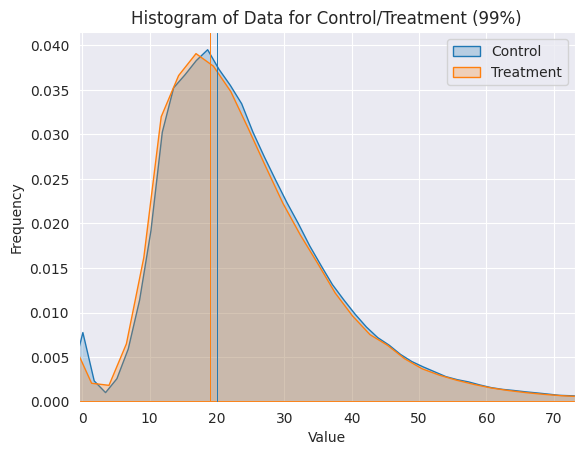

In [ ]:
# Combine the two datasets to calculate the percentiles
combined_data = np.concatenate([data_C, data_T])

# Calculate the 2.5th and 97.5th percentiles
lower_bound = np.percentile(combined_data, 0)
upper_bound = np.percentile(combined_data, 99)

# Plotting the KDE plots for both Control and Treatment
sns.kdeplot(data_C, color=_colors[0], label="Control", fill=True)
sns.kdeplot(data_T, color=_colors[1], label="Treatment", fill=True)
plt.axvline(x=true_mean_C, color=_colors[0], linewidth=0.7, linestyle="-")
plt.axvline(x=true_mean_T, color=_colors[1], linewidth=0.7, linestyle="-")

# Set the x-axis limits
plt.xlim([lower_bound, upper_bound])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Control/Treatment (99%)')
plt.legend()
plt.show()

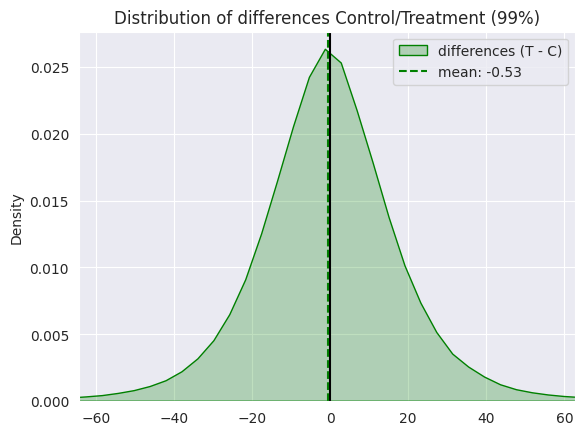

In [ ]:
# Get differences (assuming sample ratio is 50/50)
differences = data_T - data_C

# Calculate the 2.5th and 97.5th percentiles of the differences (center around 0)
lower_bound = np.percentile(differences, 0.5)
upper_bound = np.percentile(differences, 99.5)

# Plotting the KDE plot
sns.kdeplot(differences, label="differences (T - C)", fill=True, color="green")
plt.axvline(x=np.mean(differences), color = "green", linestyle = "--", label = f"mean: {round(np.mean(differences), 2)}")
plt.axvline(x=0, color="black")
plt.title('Distribution of differences Control/Treatment (99%)')

# Set the x-axis limits to capture 99% of the data
plt.xlim([lower_bound, upper_bound])
plt.legend()
plt.show()

---
# Part 2: Specify Priors

Assume Conjugate normal priors with distinct means and variances

In [ ]:
# Control
delta_h0 = 0
sigma_h0 = 10

# Treatment
delta_h1 = 0
sigma_h1 = 10

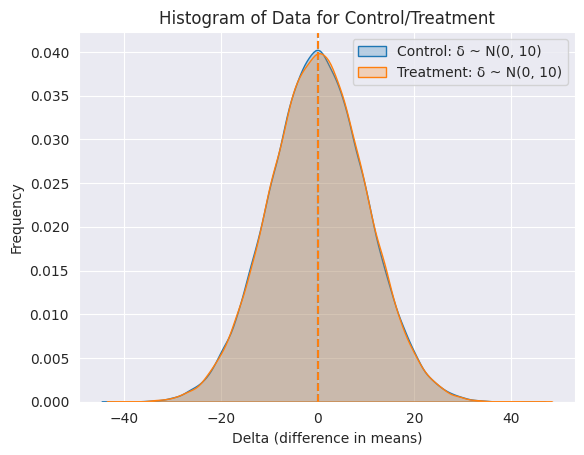

In [ ]:
# Sample from prior distribution
prior_samples_control = np.random.normal(delta_h0, sigma_h0, 100000)
prior_samples_treatment = np.random.normal(delta_h1, sigma_h1, 100000)

# Histogram of sampled data
sns.kdeplot(prior_samples_control, fill = True, label = f'Control: δ ~ N({delta_h0}, {sigma_h0})')
sns.kdeplot(prior_samples_treatment, fill = True, label = f'Treatment: δ ~ N({delta_h1}, {sigma_h1})')
plt.axvline(x = delta_h0, color = _colors[0], linestyle = "--")
plt.axvline(x = delta_h1, color = _colors[1], linestyle = "--")
plt.xlabel('Delta (difference in means)')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Control/Treatment')
plt.legend()
plt.show()

---
# Part 3: Bayes factor

Marginal likelihood ratio with the following hypotheses:

$$ \mathbf{H_0}: \delta \leq 0 \qquad\quad \mathbf{H_1}: \delta > 0 $$


Following an implementation of Deng et Al (2016), in Wan et al (2023), the following bayes factor calculation is used:

$\mu'$ is calculated as $\frac{y\sigma_i^2 + \mu_i\sigma^2}{\sigma_i^2 + \sigma^2}$
and $\sigma_i'$ as $\sqrt{\frac{1}{\sigma^2 + \sigma_i^2}}$ for $i \in \{0, 1\}$.



The exact Bayes Factor for one-sided test is:

$$
\text{BF}[H_1 : H_0] = \frac{P(y|H_1)}{P(y|H_0)}
= \frac{ \int_{\mu>0} p(y|\mu)p(\mu|H_1)d\mu}{ \int_{\mu<0} p(y|\mu)p(\mu|H_0)d\mu}
$$

$$
= \frac{1 - \Phi(-\mu_1'/\sigma_1')}{1 - \Phi(-\mu_1/\sigma_1)} \times \frac{\Phi(-\mu_0/\sigma_0)}{\Phi(-\mu_0'/\sigma_0')} \times \sqrt{\frac{\sigma_0^2 + \sigma^2}{\sigma_1^2 + \sigma^2}} \times \exp\left(\frac{-1}{2}\left(\frac{(\mu_1 - y)^2}{\sigma^2 + \sigma_1^2}\right) + \frac{1}{2}\left(\frac{(\mu_0 - y)^2}{\sigma^2 + \sigma_0^2}\right)\right)
$$

With

$$
P(y|H_0) = \int_{\mu<0} p(y|\mu)p(\mu|H_0)d\mu =
\frac{1}{\sqrt{2\pi(\sigma_0^2 + \sigma^2)}} \exp \left( - \frac{1}{2} \frac{(\mu_0 - y)^2}{\sigma^2 + \sigma_0^2} \right) \frac{\Phi(-\mu_0'/\sigma_0')}{\Phi(-\mu_0/\sigma_0)}
$$

and

$$
P(y|H_1) = \int_{\mu>0} p(y|\mu)p(\mu|H_1)d\mu =
\frac{1}{\sqrt{2\pi(\sigma_1^2 + \sigma^2)}} \exp \left( - \frac{1}{2} \frac{(\mu_1 - y)^2}{\sigma^2 + \sigma_1^2} \right) \frac{1 - \Phi(-\mu_1'/\sigma_1')}{1 - \Phi(-\mu_1/\sigma_1)}
$$



In [ ]:
def phi(x):
    """Cumulative distribution function for standard normal distribution."""
    return norm.cdf(x)

In [ ]:
def h0(y, sigma, mu_h0, sigma_h0, mu_h0_prime, sigma_h0_prime):
    fraction = phi(-mu_h0_prime / sigma_h0_prime) / phi(-mu_h0 / sigma_h0)
    exp_term = np.exp(-0.5 * ((mu_h0 - y)**2 / (sigma**2 + sigma_h0**2)))
    scalar = 1 / np.sqrt(2 * np.pi * (sigma**2 + sigma_h1**2))

    marginal_likelihood = scalar * exp_term * fraction

    return marginal_likelihood

In [ ]:
def h1(y, sigma, mu_h1, sigma_h1, mu_h1_prime, sigma_h1_prime):
    fraction = (1 - phi(-mu_h1_prime / sigma_h1_prime)) / (1 - phi(-mu_h1 / sigma_h1))
    exp_term = np.exp(-0.5 * ((mu_h1 - y)**2 / (sigma**2 + sigma_h1**2)))
    scalar = 1 / np.sqrt(2 * np.pi * (sigma**2 + sigma_h1**2))

    marginal_likelihood = scalar * exp_term * fraction

    return marginal_likelihood

In [ ]:
def update_mean(y, mu, sigma, sigma_prior):
    """Compute the updated mean after observing the data."""
    return (y * sigma_prior**2 + mu * sigma**2) / (sigma_prior**2 + sigma**2)

def update_sd(sigma, sigma_prior):
    """Compute the updated standard deviation after observing the data."""
    return np.sqrt(1 / (1/sigma**2 + 1/sigma_prior**2))

In [ ]:
def bayes_factor(y, mu_h0, sigma_h0, mu_h1, sigma_h1, sigma, n):
    """Compute the Bayes Factor given the data and hypotheses."""

    mu_h0_prime = update_mean(y, mu_h0, sigma, sigma_h0)
    mu_h1_prime = update_mean(y, mu_h1, sigma, sigma_h1)
    sigma_h0_prime = update_sd(sigma, sigma_h0)
    sigma_h1_prime = update_sd(sigma, sigma_h1)

    p_y_h0 = h0(y, sigma, mu_h0, sigma_h0, mu_h0_prime, sigma_h0_prime)
    p_y_h1 = h1(y, sigma, mu_h1, sigma_h1, mu_h1_prime, sigma_h1_prime)

    BF = (p_y_h1 / p_y_h0)

    return BF

## Early stopping

Settings:
- ```k``` = Bayes factor early stopping criteria
- ```interim_test_interval``` = stepsize for sequential tests
- ```enable_es``` = continue/stop after triggering stopping criteria
- ```minimum_sample``` = minimum sample size (accounting for potential volatility in small samples)

In [ ]:
# Settings
k = 30
interim_test_interval = 100
enable_es = True
minimum_sample = 500

In [ ]:
# Initialise
bf, n_observed = 0, minimum_sample

 # first n_observed is kind of cold start n (n_observed >= 2)
interim_tests = []

while n_observed <= len(data_T):
    # Get delta & sigma (given n_observed)
    delta_n = data_T[:n_observed].mean() - data_C[:n_observed].mean()
    sigma_n = data_C[:n_observed].var()/n_observed + data_T[:n_observed].var()/n_observed
    sigma_n = np.sqrt(sigma_n)

    # Get & store (beta) Bayes Factor
    bf = bayes_factor(delta_n, delta_h0, sigma_h0, delta_h1, sigma_h1, sigma_n, n_observed)
    interim_tests.append((n_observed, bf))

    # Stopping criteria
    if enable_es == True and (bf > k or bf < 1/k):
        break

    # Extend sample & get conversions
    n_observed += interim_test_interval


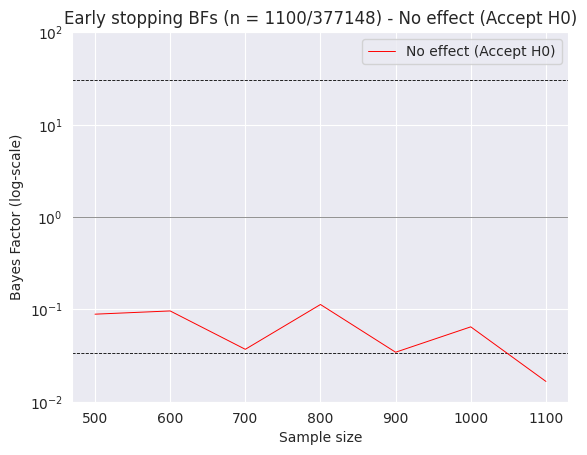

In [ ]:
def plot_early_stopping(interim_tests):
    # plot stopping criteria
    plt.axhline(y = 1, color = "grey", linewidth = "0.6")
    plt.axhline(y = k, color = "black", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = 1/k, color = "black", linestyle = "--", linewidth = "0.6")

    # Plot interim testing Bayes-Factor development
    if interim_tests[-1][1] > 1: # Reject H0 (Effect discovery)
        color_i = "green"
        conclusion = "Significant effect (Reject H0)"
    else: # Accept H0 (No effect)
        color_i = "red"
        conclusion = "No effect (Accept H0)"

    x, y = zip(*interim_tests)
    plt.plot(x, y, linestyle = "-", linewidth = 0.7, color = color_i, label = conclusion)

    # Set the y-axis to log scale
    plt.yscale('log')
    plt.xlabel("Sample size")
    plt.ylabel("Bayes Factor (log-scale)")
    plt.legend()
    plt.title(f"Early stopping BFs (n = {interim_tests[-1][0]}/{len(data_T)}) - {conclusion}")
    plt.ylim(0.01, 100)
    plt.show()

plot_early_stopping(interim_tests)

In [ ]:
# Print fixed-horizon experiment details
print(f"Priors: \nH0: delta = {delta_h0}, sigma = {sigma_h0} \nH1: delta = {delta_h1}, sigma = {sigma_h1}")
print(f"\nData full: \nC: mean = {data_C.mean():.3f}, sigma = {data_C.var():.3f}, N = {len(data_C)} \nT: mean = {data_T.mean():.3f}, sigma = {data_T.var():.3f}, N = {len(data_T)} \ndelta = {delta:.3f}, sigma = {sigma:.3f}")

# Get observed data, based on n_observed (early stopping sample)
delta_n = data_T[:n_observed].mean() - data_C[:n_observed].mean()
sigma_n = data_C[:n_observed].var()/n_observed + data_T[:n_observed].var()/n_observed

# Print early stopping experiment details (if triggered)
if n_observed < N:
  print(f"\nData observed (Early stopped): \nC: mean = {data_C[:n_observed].mean():.3f}, sigma = {data_C[:n_observed].var():.3f}, N = {min(len(data_C), n_observed)} \nT: mean = {data_T[:n_observed].mean():.3f}, sigma = {data_T[:n_observed].var():.3f}, N = {min(len(data_T), n_observed)} \ndelta = {delta_n:.3f}, sigma = {sigma_n:.3f}")
else:
  print("\nEarly stopping not triggered")

# Print sample size & associated time (assuming equal time distributions over Treatment & Control for simplicity) -> convergence time is also dependent on sampling volume/speed
start_time = df.iloc[0, :]["order_datetime_local"].time().strftime("%H:%M")
termination_time = df.iloc[min(len(df) - 1, 2 * n_observed), :]['order_datetime_local'].time().strftime("%H:%M")

print(f"\nExperiment duration: {start_time}-{termination_time}, sample = {min(len(df), 2 * n_observed)}")

Priors: 
H0: delta = 0, sigma = 10 
H1: delta = 0, sigma = 10

Data full: 
C: mean = 25.096, sigma = 200.605, N = 377148 
T: mean = 24.570, sigma = 200.848, N = 377148 
delta = -0.527, sigma = 0.004

Data observed (Early stopped): 
C: mean = 21.280, sigma = 133.332, N = 1100 
T: mean = 20.269, sigma = 112.527, N = 1100 
delta = -1.011, sigma = 0.224

Experiment duration: 12:00-12:03, sample = 2200
